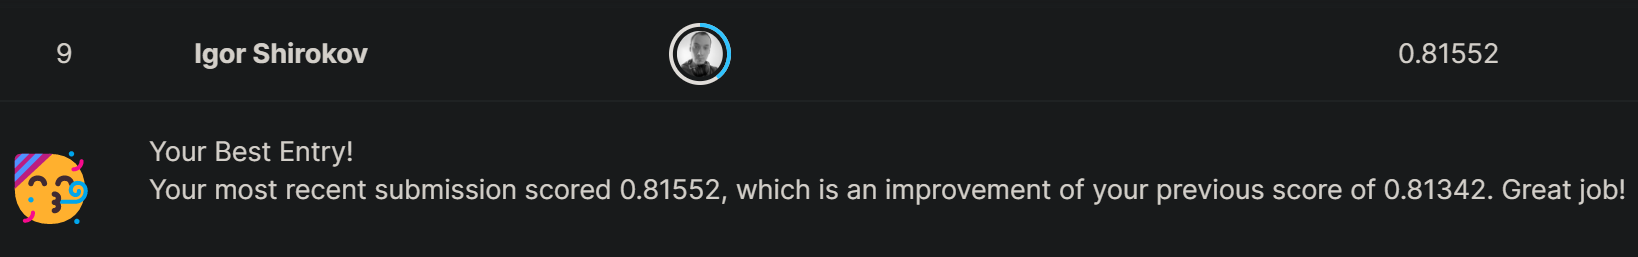

# Import Libraries

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.impute import IterativeImputer

import optuna
from catboost import CatBoostClassifier, Pool, cv

import datetime

Basic settings. They improve the visual appearance of charts and hide unnecessary logs and warnings.

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

# Extract Transform Load (ETL)

Load and merge dataframes.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)

(8693, 14) (4277, 13)


In [4]:
df = pd.concat([train, test],
               ignore_index=True,
               axis=0).reset_index(drop=True)
df.head(10)

PassengerId HomePlanet CryoSleep  Cabin    Destination    Age    VIP  \
0     0001_01     Europa     False  B/0/P    TRAPPIST-1e 39.000  False   
1     0002_01      Earth     False  F/0/S    TRAPPIST-1e 24.000  False   
2     0003_01     Europa     False  A/0/S    TRAPPIST-1e 58.000   True   
3     0003_02     Europa     False  A/0/S    TRAPPIST-1e 33.000  False   
4     0004_01      Earth     False  F/1/S    TRAPPIST-1e 16.000  False   
5     0005_01      Earth     False  F/0/P  PSO J318.5-22 44.000  False   
6     0006_01      Earth     False  F/2/S    TRAPPIST-1e 26.000  False   
7     0006_02      Earth      True  G/0/S    TRAPPIST-1e 28.000  False   
8     0007_01      Earth     False  F/3/S    TRAPPIST-1e 35.000  False   
9     0008_01     Europa      True  B/1/P    55 Cancri e 14.000  False   

   RoomService  FoodCourt  ShoppingMall      Spa  VRDeck                Name  \
0        0.000      0.000         0.000    0.000   0.000     Maham Ofracculy   
1      109.000      9.000        25.000  549.000  44.000        Juanna Vines   
2       43.000   3576.000         0.000 6715.000  49.000       Altark Susent   
3        0.000   1283.000       371.000 3329.000 193.000        Solam Susent   
4      303.000     70.000       151.000  565.000   2.000   Willy Santantines   
5        0.000    483.000         0.000  291.000   0.000   Sandie Hinetthews   
6       42.000   1539.000         3.000    0.000   0.000  Billex Jacostaffey   
7        0.000      0.000         0.000    0.000     NaN  Candra Jacostaffey   
8        0.000    785.000        17.000  216.000   0.000       Andona Beston   
9        0.000      0.000         0.000    0.000   0.000      Erraiam Flatic   

  Transported  
0       False  
1        True  
2       False  
3       False  
4        True  
5        True  
6        True  
7        True  
8        True  
9        True

# Exploratory Data Analysis (EDA)

First of all, let's evaluate the balance of classes. The classes are well balanced, we will assume the same picture is observed in the test dataframe.

In [5]:
train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Let's use pandas_profiling to get some basic information about our data.

In [6]:
profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report', dark_mode=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It follows from the report that there are few NaN, but they are scattered around. 

CryoSleep is most associated with the target variable.

Conclusions by age were confirmed, the distribution turned out to be strange (why are there so many children on the ship?), but it is not worth correcting the data.

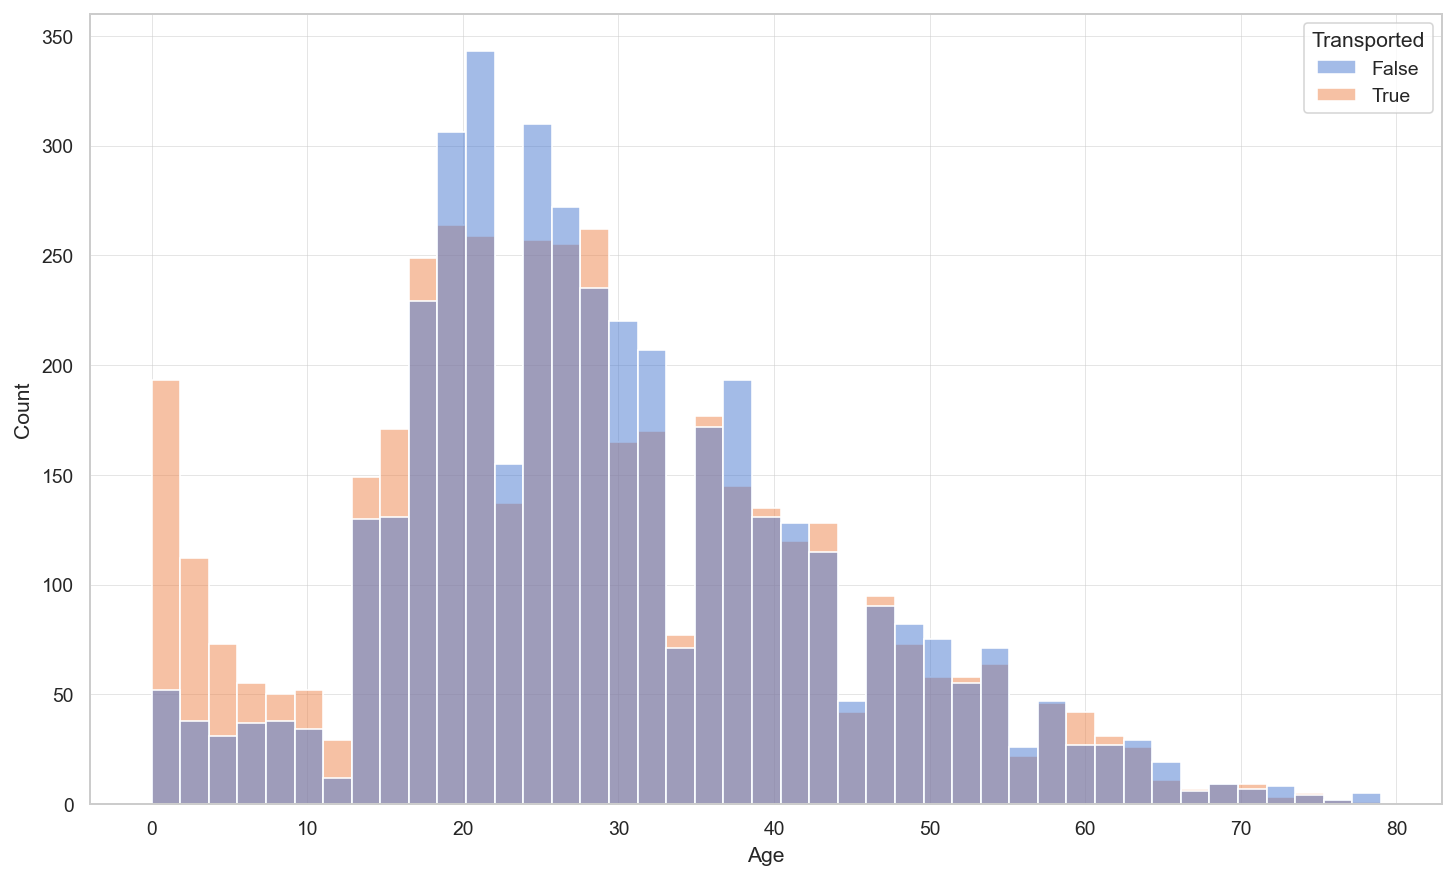

In [7]:
sns.histplot(data=train, x='Age', hue='Transported');

There are quite a lot of outliers in spending, for better visualization we use the np.log1p function to the data. The impact of spending on the target variable is now clearly visible.

Excluding missings variables, most of those who didn't transported spent less money.

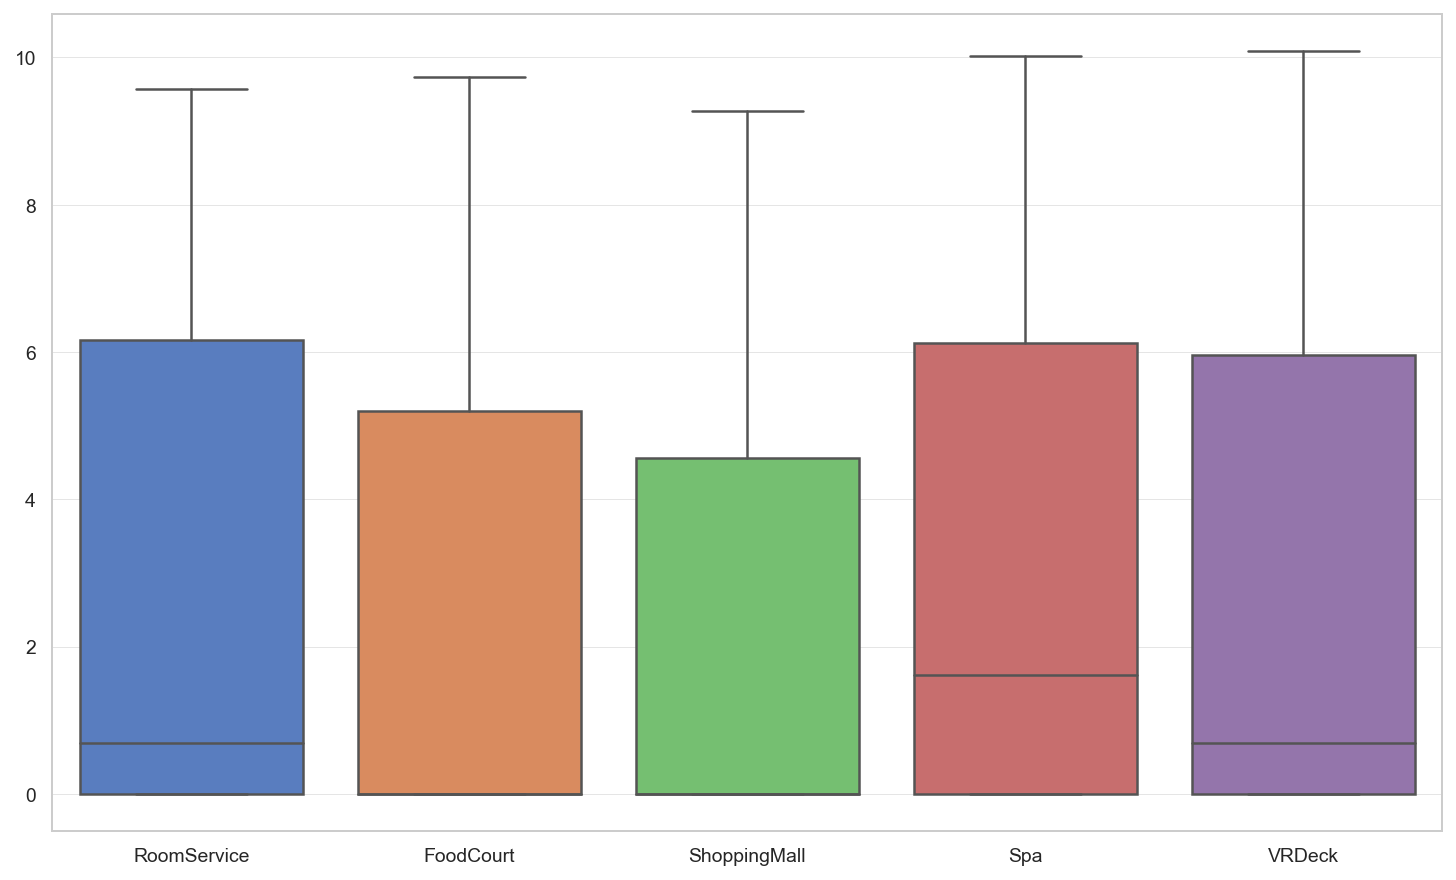

In [8]:
sns.boxplot(data=train
            .query('Transported == False')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
            .apply(np.log1p));

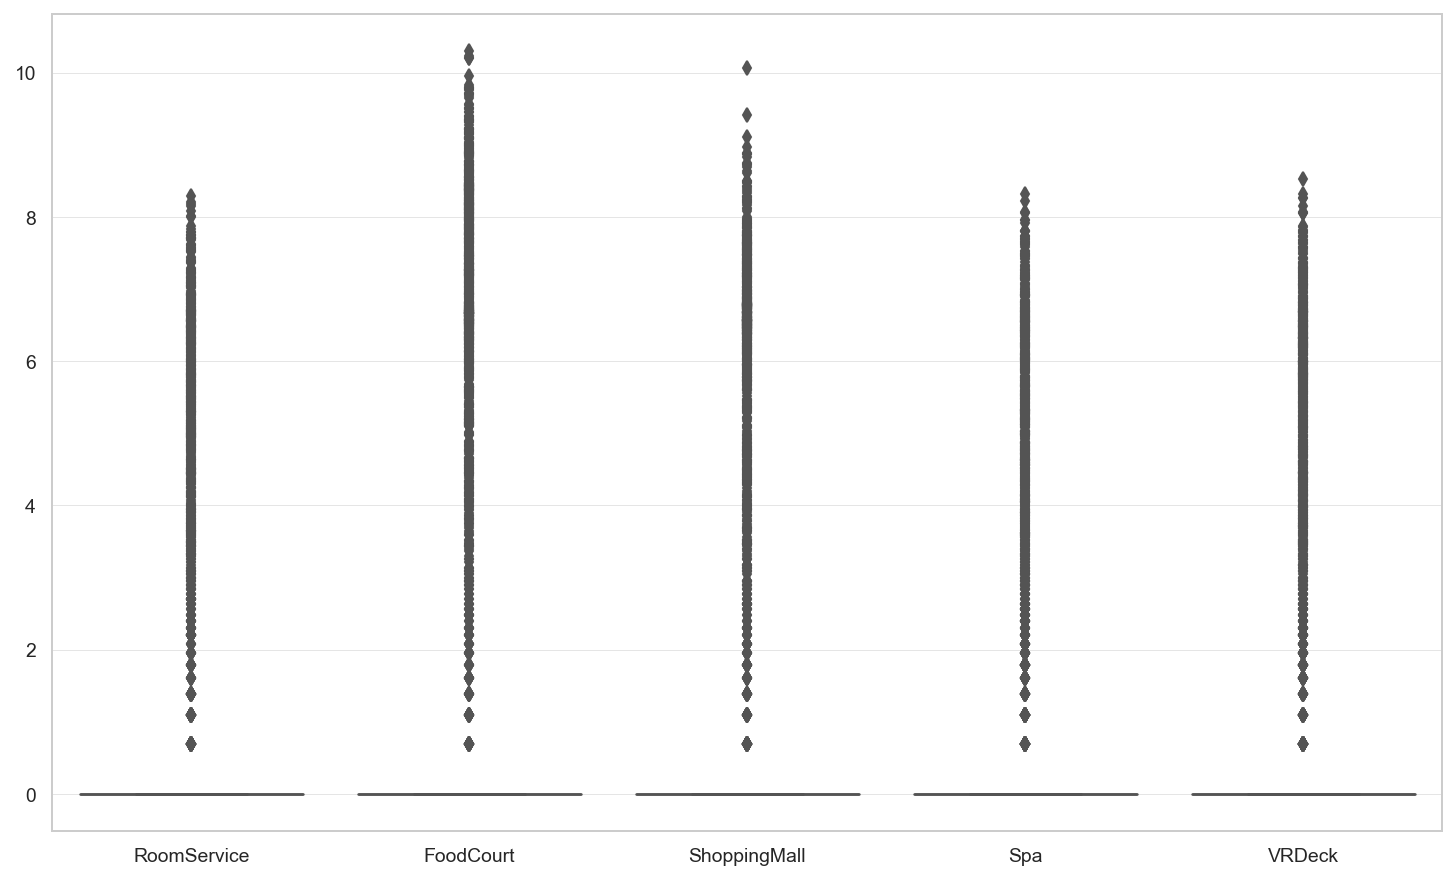

In [9]:
sns.boxplot(data=train
            .query('Transported == True')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
            .apply(np.log1p));

If CryoSleep == True, then there are no expenses, which is logical.

In [10]:
df[df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) > 0].query('CryoSleep == True')

Empty DataFrame
Columns: [PassengerId, HomePlanet, CryoSleep, Cabin, Destination, Age, VIP, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Name, Transported]
Index: []

Age is also associated with spending.

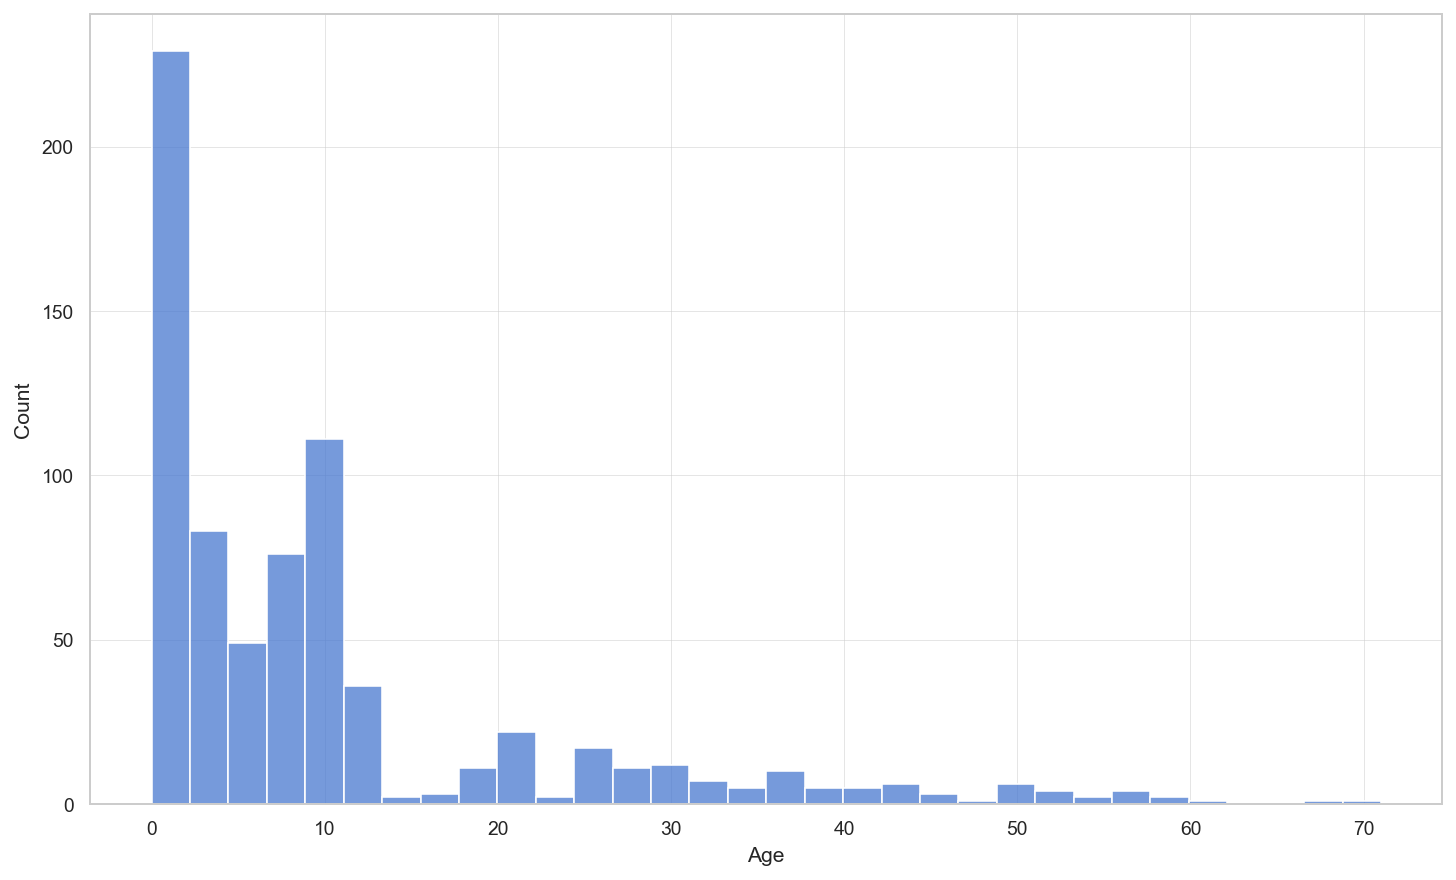

In [11]:
sns.histplot(
    data=df[df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) == 0].query('CryoSleep == False').Age
);

There are no VIP's from Earth on board.

In [12]:
df.query('VIP == True').value_counts('HomePlanet')

HomePlanet
Europa    177
Mars       90
dtype: int64

In [13]:
df.query('VIP == False').value_counts('HomePlanet')

HomePlanet
Earth     6706
Europa    2883
Mars      2533
dtype: int64

# Conclusions:

* PassengerId contains a number after the '_' which may indicate a group. For people with the same last name, id increases. Logically, the survival rate of singles should be different from those who flew in a group.
* The total expenditure should be added.

# Models

It' better to use some categorical features to fill na in quantitative data too.

Define filler function.

In [14]:
def filler(X, num_features, cat_features):
    X = X.copy()
    
    X[cat_features] = X[cat_features].fillna('unknown').astype(str)
    X = pd.get_dummies(X, drop_first=True)
    
    columns = X.columns
    
    imputer = IterativeImputer(initial_strategy='median', random_state=38)
    X = imputer.fit_transform(X)
    
    return pd.DataFrame(X, columns=columns)[num_features].astype(int)

Let's create a FeatureTransformer that will transform the data before sending it to the model.

In [15]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Make a copy() to not change the data in the main dataframe.
        X = X.copy()
        
        # Unpack the data by creating additional features.
        X[['party_n', 'party_count']] = X.PassengerId.str.split('_', expand=True)
        X['group_size'] = X.groupby('party_n').party_n.transform('count')
        X[['cab_1', 'cab_2', 'cab_3']] = X.Cabin.str.split('/', expand=True)
        X['cab_2'] = X.cab_2.astype(float)
        
        # Let's remove the useless data.
        X.drop(columns=['Name', 'Cabin', 'PassengerId', 'party_count'],
               inplace=True)
        
        # Fill VIP values where we certain.
        X['VIP'] = X.VIP.fillna(X.HomePlanet.apply(lambda x: False if x == 'Earth' else np.nan))
        
        # Now, use IterativeImputertor fill gaps in quantitative data.
        X.query('CryoSleep == True').loc[:, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = \
            X.query('CryoSleep == True').loc[:, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)
        
        # Сalculate the total cost.
        X['expenditure'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
        
        # Costs are zero if the passenger is in cryosleep.
        X['CryoSleep'] = X.CryoSleep.fillna(X.expenditure.apply(lambda x: False if x != 0 else np.nan))
        
        # In order to avoid errors, we need to convert the boolean type to strings, otherwise with the addition of 'unknown' there will be a non-working mix.
        X['CryoSleep'] = X.CryoSleep.replace(True, 'yes').replace(False, 'no')
        X['VIP'] = X.VIP.replace(True, 'yes').replace(False, 'no')
        
        num_features = ['cab_2', 'Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        cat_features = ['Destination', 'VIP', 'cab_1']
        X[num_features] = filler(X[num_features + cat_features], num_features, cat_features)
        
        # Fill in the categories with gaps - 'unknown'.
        cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
        X[cat_features] = X[cat_features].fillna('unknown')
        X[cat_features] = X[cat_features].apply(lambda x: x.astype('category'))

        return X

Next step will be data splitting.

In [16]:
X = df.drop('Transported', axis=1)
X = FeatureTransformer().transform(X)
y = train['Transported'] * 1

X_test_final = X.iloc[y.index[-1] + 1:]

cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
full_data = Pool(X.iloc[y.index], y, cat_features)

X_train, X_test, y_train, y_test = \
    train_test_split(X.iloc[y.index], y, test_size=0.25, stratify=y, random_state=38)
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=38)

train_data = Pool(X_train, y_train, cat_features)
valid_data = Pool(X_valid, y_valid, cat_features)

Let's run optuna and select the optimal hyperparameters.

In [17]:
def objective(trial: optuna.Trial) -> float:
    
    # Model parameters.
    params = {
        'objective': 'Logloss',
        'loss_function': 'Logloss',
        'depth': trial.suggest_int('depth', 4, 7),
        'subsample': trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 0.9, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.4, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 6),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 48, 2),
        'iterations': 1250,
        # 'per_float_feature_quantization': ['1:border_count=1024']
    }

    # The Alternative that is much faster. 25-50 iterations are okay for the good result.
    # If CatBoostClassifier is used - change study direction to 'maximize'.
    
    # gbm = CatBoostClassifier(**params)
    # gbm.fit(
    #     train_data,
    #     eval_set=valid_data,
    #     verbose=0,
    #     early_stopping_rounds=125
    # )
    
    # y_hat = gbm.predict(X_test)
    # return accuracy_score(y_test, y_hat)
    
    cv_data = cv(
        pool=full_data,
        params=params,
        early_stopping_rounds=125,
        logging_level='Silent',
        fold_count=4,
        stratified=True,
        partition_random_seed=38)
    
    return cv_summary(cv_data)

Simple logging function to monitor the progress.

In [18]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

Function for displaying cross-validation results. It also return best value for optuna hyperparameters training.

In [19]:
def cv_summary(cv_data, verbose=False):
    best_value = cv_data['test-Logloss-mean'].min()
    
    if verbose == True:
        best_iter = cv_data['test-Logloss-mean'].values.argmin()

        print('Best validation Logloss score : {:.3f}±{:.3f} on step {}'.format(
            best_value,
            cv_data['test-Logloss-std'][best_iter],
            best_iter)
        )
    else:
        return best_value

Run the optuna's study.

In [20]:
study = optuna.create_study(
        study_name='Hyperparameters tuning',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        direction="minimize"
)
study.optimize(objective,
               n_trials=6, # should be much higher.
               gc_after_trial=True, # optional, sometimes help to avoid random errors.
               callbacks=[logging_callback])

print(f'Research completed! Best result: {study.best_value:.4f}')

Trial 0 finished with best value: 0.3764730169042556 and parameters: {'depth': 6, 'subsample': 0.4, 'colsample_bylevel': 0.2816703467264745, 'random_strength': 0.5355161912672503, 'l2_leaf_reg': 4.903983887457862, 'min_data_in_leaf': 24}. 
Trial 2 finished with best value: 0.3748518477341342 and parameters: {'depth': 5, 'subsample': 0.8, 'colsample_bylevel': 0.8920182662612908, 'random_strength': 0.7119718215634576, 'l2_leaf_reg': 4.462550608715791, 'min_data_in_leaf': 30}. 
Research completed! Best result: 0.3749


Let's write down the main parameters and supplement them with best_params from the opuna through the update function.

last
{'depth': 6,
 'colsample_bylevel': 0.9848560032154842,
 'random_strength': 0.2388479788615189,
 'min_data_in_leaf': 36}

In [21]:
params = {
    'objective': 'Logloss',
    'loss_function': 'Logloss',
    'iterations': 1250,
    'random_seed': 38,
    # 'per_float_feature_quantization': ['1:border_count=1024'],
    # 'eval_metric': 'Accuracy',
    }

# Optimal params (I put Trial 0 results as an example).
study_best_params = {'depth': 6,
                     'subsample': 0.4,
                     'colsample_bylevel': 0.2816703467264745,
                     'random_strength': 0.5355161912672503,
                     'l2_leaf_reg': 4.903983887457862,
                     'min_data_in_leaf': 24}

try:
    params.update(study.best_params)
except:
    # Used when we don't have optuna results.
    params.update(study_best_params)

Let's do another CV before predict the test target.

In [22]:
cv_data = cv(
    pool=full_data,
    params=params,
    early_stopping_rounds=125,
    verbose=250,
    fold_count=5,
    stratified=True,
    partition_random_seed=38)

cv_summary(cv_data, verbose=True)

Training on fold [0/5]
0:	learn: 0.6774910	test: 0.6775505	best: 0.6775505 (0)	total: 18.8ms	remaining: 23.5s
250:	learn: 0.3838129	test: 0.3960971	best: 0.3960971 (250)	total: 5.15s	remaining: 20.5s
500:	learn: 0.3552937	test: 0.3818245	best: 0.3818245 (500)	total: 10.2s	remaining: 15.2s
750:	learn: 0.3347960	test: 0.3758855	best: 0.3758127 (746)	total: 15.2s	remaining: 10.1s
1000:	learn: 0.3180378	test: 0.3723452	best: 0.3723038 (994)	total: 20.3s	remaining: 5.05s
1249:	learn: 0.3045776	test: 0.3709371	best: 0.3708485 (1198)	total: 25.3s	remaining: 0us

bestTest = 0.3708485454
bestIteration = 1198

Training on fold [1/5]
0:	learn: 0.6775004	test: 0.6771110	best: 0.6771110 (0)	total: 16.7ms	remaining: 20.8s
250:	learn: 0.3825184	test: 0.3957307	best: 0.3957307 (250)	total: 4.96s	remaining: 19.7s
500:	learn: 0.3578998	test: 0.3842247	best: 0.3842247 (500)	total: 9.73s	remaining: 14.5s
750:	learn: 0.3373140	test: 0.3766642	best: 0.3766210 (746)	total: 14.8s	remaining: 9.81s
1000:	learn:

To achieve better (less dependent from random) results we will using bootstrap technic.

In [23]:
bootstrap = pd.DataFrame()
gbm = CatBoostClassifier(**params)

for i in range(6): # should be higher.

    X_train, X_valid, y_train, y_valid = \
        train_test_split(X.iloc[y.index], y, stratify=y, test_size=0.2, random_state=i)

    train_data = Pool(X_train, y_train, cat_features)
    valid_data = Pool(X_valid, y_valid, cat_features)
    
    gbm.fit(
        train_data,
        eval_set=valid_data,
        verbose=0,
        early_stopping_rounds=125,
    )
    
    bootstrap[str(gbm.best_score_['validation']['Logloss'])[:6]] = \
        gbm.predict(X_test_final)

Visualize feature importance. It's can be seen those new features are in top 5.

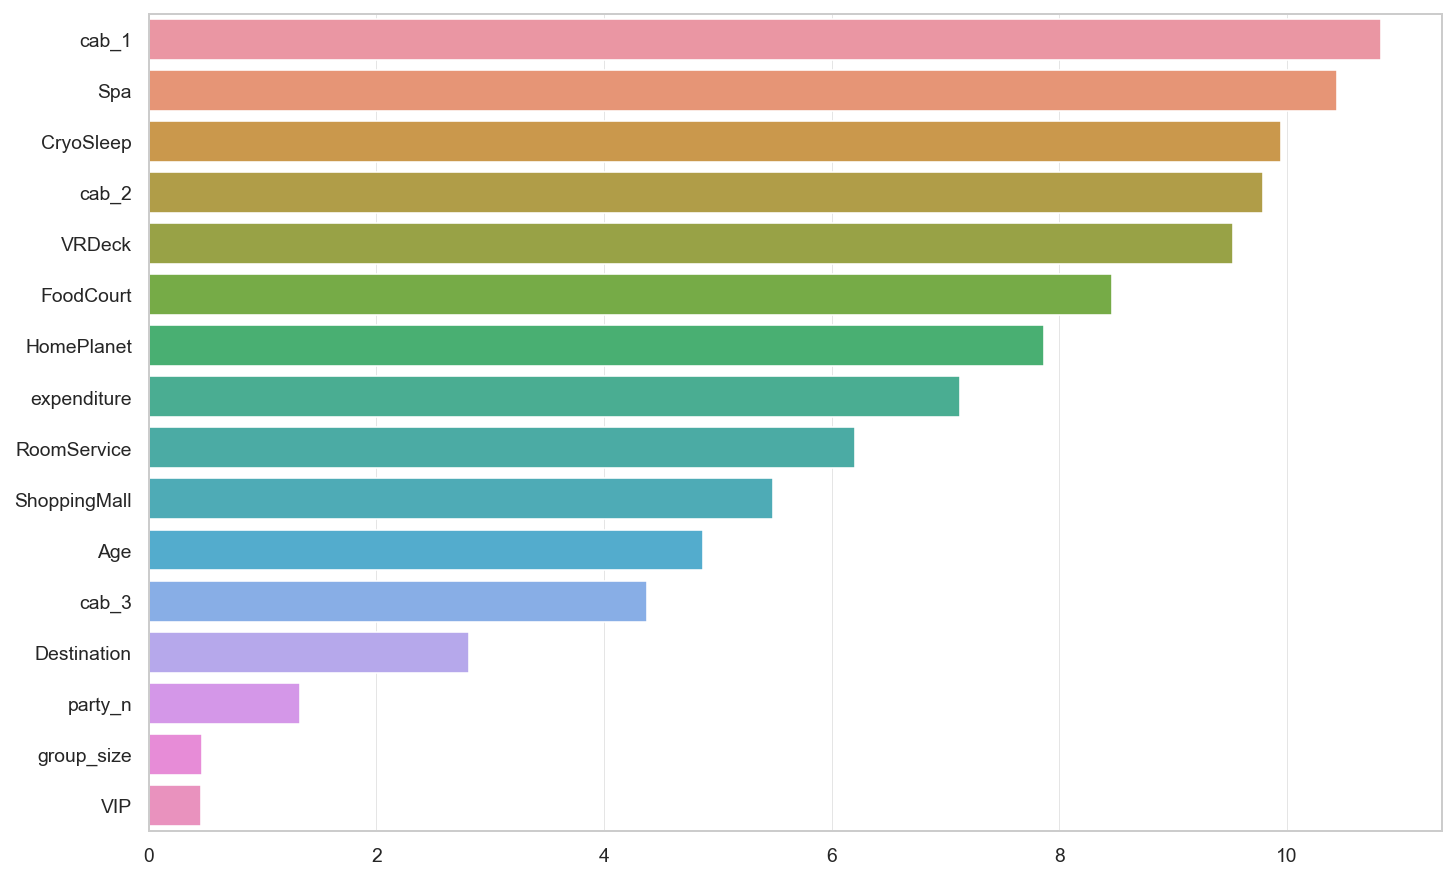

In [24]:
feature_importances = pd.Series(gbm.feature_importances_,
                                index=X.columns) \
                        .sort_values(ascending=False)

sns.barplot(y=feature_importances.index,
            x=feature_importances,
            orient='h');

Check the balance beetween classes.

In [25]:
bootstrap.reindex(sorted(bootstrap.columns), axis=1) \
    .iloc[:,:bootstrap.shape[1] // 2] \
    .mean(axis=1).apply(lambda x: x > 0.5) \
    .value_counts()

False    2140
True     2137
dtype: int64

Form the answer. We pick best half of our results based on the validation score.

In [26]:
y_hat = bootstrap.reindex(sorted(bootstrap.columns), axis=1) \
    .iloc[:, :bootstrap.shape[1] // 2] \
    .mean(axis=1) \
    .apply(lambda x: x > 0.5)

In [27]:
# Combine PassengerId and predictions.
res = pd.concat([test.PassengerId,
                 pd.Series(y_hat, index=test.index, name='Transported')],
                axis=1)

# Save the result.
file_name = 'Prediction-' + str(datetime.date.today()) + '.csv'
pd.DataFrame(res).to_csv(file_name, index=False)
print('Saved!')

Saved!


# Final Conclusions:

* 9 / 2300 result on kaggle!
* The model formed and good accuracy achieved.